# Projeto 2 - Ciência dos Dados
## 2020.2 ~ 2C ~ Estudo do stat "Velocidade" dos Pokémons
### Grupo:
    -Guilherme Rameh
    -Tales Oliveira
    -Gabriella Zullo
    -João Magalhães

In [1]:
import scipy.stats as stats
from scipy.stats import t, norm, probplot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt, ceil
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

# Para ter melhor print
from IPython.display import display

In [2]:
# Leitura do banco de dados

dados = pd.read_csv('pokemon.csv')
dados

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,['Beast Boost'],0.25,1.0,0.5,2.0,0.5,1.0,2.0,0.5,1.0,...,NaN,797,107,101,61,steel,flying,999.9,7,1
797,['Beast Boost'],1.00,1.0,0.5,0.5,0.5,2.0,4.0,1.0,1.0,...,NaN,798,59,31,109,grass,steel,0.1,7,1
798,['Beast Boost'],2.00,0.5,2.0,0.5,4.0,2.0,0.5,1.0,0.5,...,NaN,799,97,53,43,dark,dragon,888.0,7,1
799,['Prism Armor'],2.00,2.0,1.0,1.0,1.0,0.5,1.0,1.0,2.0,...,NaN,800,127,89,79,psychic,NaN,230.0,7,1


# Primeira Análise Exploratória
A seguir, verificaremos quais variáveis achamos interessantes de se relacionar com a velocidade dos Pokémons, que é nossa variável *Target*. Começamos printando as colunas do dataframe, pois sabendo do que se trata, podemos descartar algumas colunas logo de cara (como por exemplo as colunas referentes a quanto de dano cada ataque dá em cada tipo de Pokémon).

In [3]:
print(dados.dtypes)

abilities             object
against_bug          float64
against_dark         float64
against_dragon       float64
against_electric     float64
against_fairy        float64
against_fight        float64
against_fire         float64
against_flying       float64
against_ghost        float64
against_grass        float64
against_ground       float64
against_ice          float64
against_normal       float64
against_poison       float64
against_psychic      float64
against_rock         float64
against_steel        float64
against_water        float64
attack                 int64
base_egg_steps         int64
base_happiness         int64
base_total             int64
capture_rate          object
classfication         object
defense                int64
experience_growth      int64
height_m             float64
hp                     int64
japanese_name         object
name                  object
percentage_male      float64
pokedex_number         int64
sp_attack              int64
sp_defense    

<b> Lembrete: Quando lidando com duas variáveis QUANTITATIVAS, usamos scatter plot, e para variáveis QUALITATÍVAS (como estamos lidando com "speed", que é quantitativo) podemos separar por index e fazer crosstab, ou usar o comando pivot table do pandas, que permite a análise de várias variáveis qualitativas em relação a quantitativas, permitindo até o uso de comandos como média, máx e mín.

### Primeiras modificações no Dataframe

A seguir, manipulamos o dataframe com o intuito de analisar a relação da velocidade com as principais variáveis quantitativas, como ataque, defesa, etc...; Para evitar confusões e dificuldade na leitura dos gráficos, primeiro separamos os tipos de pokémons nos mais frequentes, tanto para o *tipo 1* quanto para o *tipo 2*. Nessa etapa também separamos o dataframe em dois, um de treino e um para testarmos o quão fíel é o nosso modelo.

In [4]:
for i in dados.index:
    type1 = dados.type1[i]
    if type1 == 'water':
        dados.loc[dados.index==i, 'Type1Reorder'] = 'water'
    elif type1 == 'normal':
        dados.loc[dados.index==i, 'Type1Reorder'] = 'normal'
    else:
        dados.loc[dados.index==i, 'Type1Reorder'] = 'other'
        
    type2 = dados.type2[i]
    if type2 == 'flying':
        dados.loc[dados.index==i, 'Type2Reorder'] = 'flying'
    elif type2 == 'ground':
        dados.loc[dados.index==i, 'Type2Reorder'] = 'ground'
    else:
        dados.loc[dados.index==i, 'Type2Reorder'] = 'other'
        
dados.tail(20)

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary,Type1Reorder,Type2Reorder
781,"['Bulletproof', 'Soundproof', 'Overcoat']",1.00,1.0,2.0,0.5,2.0,1.00,0.5,1.0,1.0,...,45,45,45,dragon,NaN,29.7,7,0,other,other
782,"['Bulletproof', 'Soundproof', 'Overcoat']",0.50,0.5,2.0,0.5,4.0,1.00,0.5,2.0,1.0,...,65,70,65,dragon,fighting,47.0,7,0,other,other
783,"['Bulletproof', 'Soundproof', 'Overcoat']",0.50,0.5,2.0,0.5,4.0,1.00,0.5,2.0,1.0,...,100,105,85,dragon,fighting,78.2,7,0,other,other
784,"['Electric Surge', 'Telepathy']",0.50,0.5,0.0,0.5,1.0,0.50,1.0,0.5,1.0,...,95,75,130,electric,fairy,20.5,7,1,other,other
785,"['Psychic Surge', 'Telepathy']",1.00,1.0,0.0,1.0,1.0,0.25,1.0,1.0,2.0,...,130,115,95,psychic,fairy,18.6,7,1,other,other
786,"['Grassy Surge', 'Telepathy']",1.00,0.5,0.0,0.5,1.0,0.50,2.0,2.0,1.0,...,85,95,75,grass,fairy,45.5,7,1,other,other
787,"['Misty Surge', 'Telepathy']",0.50,0.5,0.0,2.0,1.0,0.50,0.5,1.0,1.0,...,95,130,85,water,fairy,21.2,7,1,water,other
788,['Unaware'],2.00,2.0,1.0,1.0,1.0,0.50,1.0,1.0,2.0,...,29,31,37,psychic,NaN,0.1,7,1,other,other
789,['Sturdy'],2.00,2.0,1.0,1.0,1.0,0.50,1.0,1.0,2.0,...,29,131,37,psychic,NaN,999.9,7,1,other,other
790,['Full Metal Body'],1.00,2.0,0.5,1.0,0.5,1.00,2.0,0.5,2.0,...,113,89,97,psychic,steel,230.0,7,1,other,other


In [5]:
dummies_type1 = pd.get_dummies(dados['type1'])
dummies_type2 = pd.get_dummies(dados['type2'])

for i in dummies_type1:
    dados.loc[:,'T1_'+i] = dummies_type1[i]
    dados.loc[:,'T2_'+i] = dummies_type2[i]
    
dados

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,T1_poison,T2_poison,T1_psychic,T2_psychic,T1_rock,T2_rock,T1_steel,T2_steel,T1_water,T2_water
0,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,0,1,0,0,0,0,0,0,0,0
1,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,0,1,0,0,0,0,0,0,0,0
2,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,0,1,0,0,0,0,0,0,0,0
3,"['Blaze', 'Solar Power']",0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,"['Blaze', 'Solar Power']",0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,['Beast Boost'],0.25,1.0,0.5,2.0,0.5,1.0,2.0,0.5,1.0,...,0,0,0,0,0,0,1,0,0,0
797,['Beast Boost'],1.00,1.0,0.5,0.5,0.5,2.0,4.0,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
798,['Beast Boost'],2.00,0.5,2.0,0.5,4.0,2.0,0.5,1.0,0.5,...,0,0,0,0,0,0,0,0,0,0
799,['Prism Armor'],2.00,2.0,1.0,1.0,1.0,0.5,1.0,1.0,2.0,...,0,0,1,0,0,0,0,0,0,0


In [6]:
lista_train_test = train_test_split(dados, shuffle=True)
train = lista_train_test[0]
test = lista_train_test[1]

# size = 600
# list_of_dfs = [shuffle.iloc[:600,:], shuffle.iloc[600:,:]]
# train = list_of_dfs[0]
# test = list_of_dfs[1]

In [7]:
# Aqui vemos a quantidade de cada tipo, 1 e 2, na base de treino

print(train['type1'].value_counts())
print('\n')
print(train['type2'].value_counts())

water       91
normal      72
grass       58
bug         52
psychic     41
fire        35
rock        33
electric    33
ground      27
dragon      24
dark        22
poison      21
ghost       21
ice         18
fighting    18
fairy       16
steel       16
flying       2
Name: type1, dtype: int64


flying      74
poison      27
ground      27
fairy       22
psychic     19
fighting    18
steel       18
dark        17
water       14
ice         12
grass       11
ghost       10
dragon       9
fire         8
rock         8
electric     7
bug          5
normal       4
Name: type2, dtype: int64


### Análise com o modelo de distribuição "Normal"

Na célula seguinte, usamos o *probplot* e um histograma para analisar a normalidade da variável 'velocidade'. Podemos ver que ela não se distancia tanto da normal, principalmente na cauda esquerda.

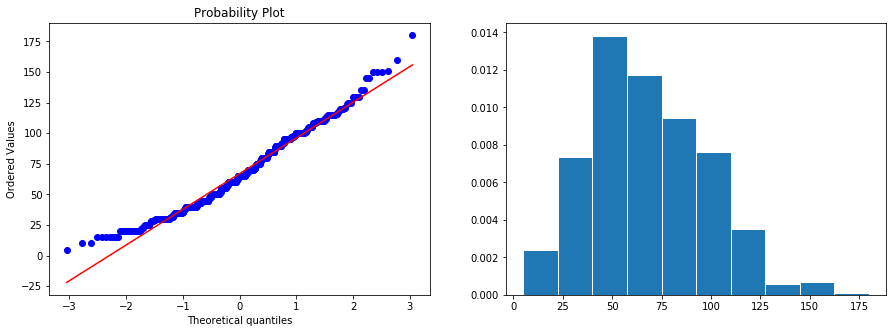

In [8]:
plt.figure(figsize=(15,5))

plt.subplot(121)
probplot(train['speed'], dist='norm', plot=plt)

plt.subplot(122)
plt.hist(train['speed'], density=True, edgecolor='w');

## Plot inicial
Como maneira de visualizar melhor se as variáveis tem relação ao *Target*, plotamos os gráficos *scatterplot* de relação entre as diversas variáveis quantitativas, além de separar por tipos de Pokémon, para ver se com isso conseguíamos visualizar alguma relação, que como se perceberá logo, é bem difícil.

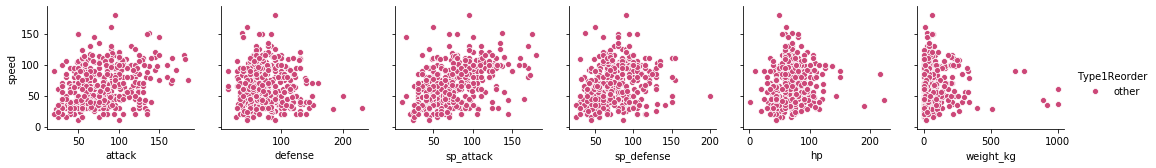

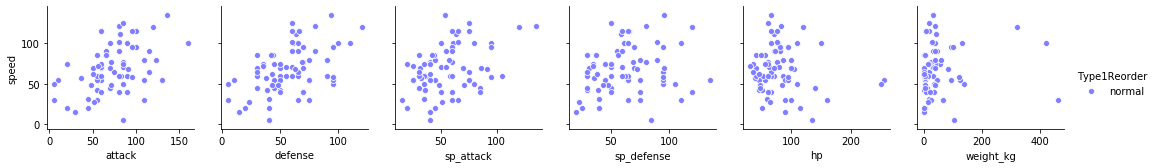

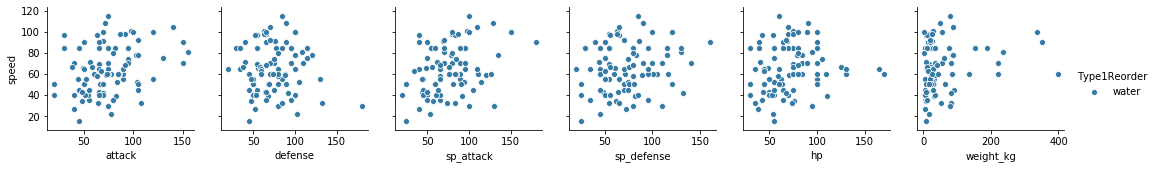

In [9]:
listType1 = train.Type1Reorder.unique()
listType2 = train.Type2Reorder.unique()
colorlist = ['plasma', 'cool', 'mako']

for i in range(3):
    e = listType1[i]
    df = train.loc[train.Type1Reorder==e, :]
    sns.pairplot(df, palette=colorlist[i],
        x_vars=["attack", 'defense', 'sp_attack', 'sp_defense', 'hp', 'weight_kg'],
        y_vars=['speed'],
        hue='Type1Reorder', height=2.5);

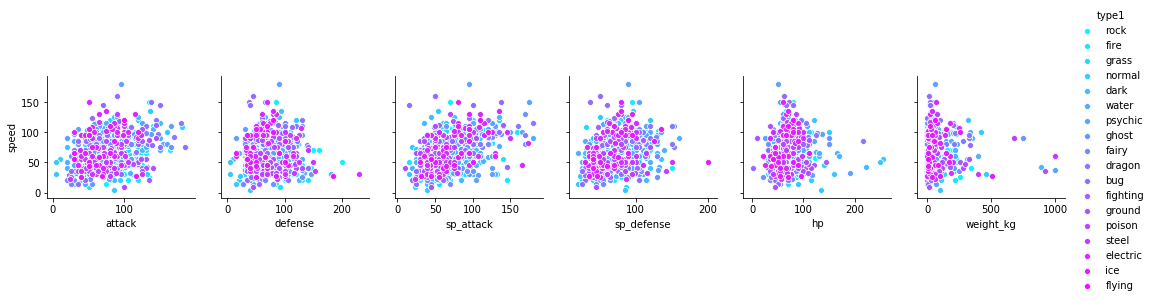

In [10]:
sns.pairplot(train,
        x_vars=["attack", 'defense', 'sp_attack', 'sp_defense', 'hp', 'weight_kg'],
        y_vars=['speed'], palette='cool',hue='type1', height=2.5);

## Regressão
Percebendo que assim não conseguiríamos identificar nenhuma relação, optamos por usar a biblioteca <b>statsmodel.api</b> para fazer a regressão pelo método dos Mínimos Quadrados. 

*Usamos apenas algumas variáveis, pois no contexto do dataframe e do jogo Pokémon sabemos que fazem referência a outros detalhes que não vão influenciar na velocidade do Pokémon, além de alguns conterem termos NaN, que atrapalham o uso deles como treino*

In [11]:
X = train[['attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'is_legendary', 'generation', 'experience_growth']]

Y = train[['speed']]

In [12]:
def regress(Y,X):
    '''
    Y: coluna do DataFrame utilizada como variável resposta (TARGET)
    X: coluna(s) do DataFrame utilizadas como variável(is) explicativas (FEATURES)
    '''
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    
    return results

In [13]:
results = regress(Y,X)
results.summary()

C:\Users\guilh\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     33.95
Date:                Mon, 23 Nov 2020   Prob (F-statistic):           4.12e-44
Time:                        12:07:10   Log-Likelihood:                -2765.8
No. Observations:                 600   AIC:                             5550.
Df Residuals:                     591   BIC:                             5589.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                47.3753      8.043      5.890      0.000      31.578      63.172
attack                0.3356      0.039      8.548      0.000       0.258       0.413
defense              -0.3116      0.043     -7.190      0.000      -0.397      -0.226
sp_attack             0.2652      0.040      6.687      0.000       0.187       0.343
sp_defense            0.1444      0.050      2.892      0.004       0.046       0.242
hp                   -0.1350      0.041     -3.260      0.001      -0.216      -0.054
is_legendary         18.2787      4.095      4.463      0.000      10.235      26.322
generation           -1.0035      0.526     -1.908      0.057      -2.037       0.030
experience_growth -1.979e-06   7.01e-06     -0.282      0.778   -1.57e-05    1.18e-05
==============================================================================
Omnibus:                       20.995   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.867
Skew:                           0.421   Prob(JB):                     1.08e-05
Kurtosis:                       3.452   Cond. No.                     8.88e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.88e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Analisando os resultados acima, percebemos que TODOS (com excessão de "experience_growth") são importantes para definir nossa variável *Target*, ou seja, a velocidade ("speed"). Apesar disso, nosso P é bem pequeno, o que não é um bom sinal, e portanto precisaremos de mais regressões se quisermos atingir a normalidade e poder prever fielmente nosso *Target*.

## Análise Rápida da previsão "como está"
Apenas para visualizarmos, abaixo segue o plot do predict (ou seja, a previsão que a biblioteca $sm$ faz) relacionado com os valores reais do nosso dataframe *teste*.

In [14]:
X_test = test[['attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'is_legendary', 'generation', 'experience_growth']]

Y_test = test[['speed']]

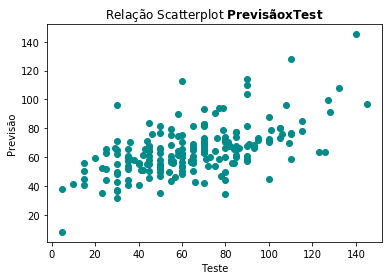

In [15]:
X_cp = sm.add_constant(X_test)
Y_predTest = results.predict(X_cp)

plt.title(r'Relação Scatterplot $\bf{Previsão x Test}$')
plt.xlabel('Teste')
plt.ylabel('Previsão')
plt.scatter(Y_test, Y_predTest, color='darkcyan');

## Aprofundamento na Análise Exploratória
Para aprimorarmos nossa previsão da velocidade dos Pokémons, precisamos também considerar variáveis <b>qualitativas</b>. Porém, a biblioteca $sm$ lida apenas com variáveis <b>quantitativas</b>. Como podemos então transformar essas variáveis para podermos analisar melhor nosso dataframe? A resposta é: com $Dummies$. Dummies é um comando da biblioteca $pandas$ que transforma as strings de uma classificação qualitativa em colunas de um dataframe assumindo valores de 0 ou 1, que equivalem a False e True, respectivamente. Assim, podemos usar essas novas colunas para uma análise exploratória mais aprofundada.

In [16]:
X_Types = train.iloc[:,43:]
X_Types 

,T1_bug,T2_bug,T1_dark,T2_dark,T1_dragon,T2_dragon,T1_electric,T2_electric,T1_fairy,T2_fairy,...,T1_poison,T2_poison,T1_psychic,T2_psychic,T1_rock,T2_rock,T1_steel,T2_steel,T1_water,T2_water
246,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
726,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
792,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
462,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
282,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
601,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
results = regress(Y,X_Types)
results.summary()

C:\Users\guilh\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\guilh\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\guilh\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\guilh\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\guilh\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is dep

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     3.459
Date:                Mon, 23 Nov 2020   Prob (F-statistic):           4.10e-10
Time:                        12:07:10   Log-Likelihood:                -2820.9
No. Observations:                 600   AIC:                             5714.
Df Residuals:                     564   BIC:                             5872.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          60.4356      1.973     30.632      0.000      56.560      64.311
T1_bug          0.5454      4.197      0.130      0.897      -7.698       8.789
T2_bug         -9.5017     12.676     -0.750      0.454     -34.400      15.396
T1_dark         7.9634      5.875      1.355      0.176      -3.576      19.503
T2_dark        13.5415      6.980      1.940      0.053      -0.169      27.252
T1_dragon      10.7391      5.620      1.911      0.057      -0.299      21.777
T2_dragon       8.0346      9.755      0.824      0.410     -11.126      27.195
T1_electric    24.8248      4.942      5.023      0.000      15.117      34.532
T2_electric     1.9734     10.712      0.184      0.854     -19.066      23.013
T1_fairy       -7.1118      6.759     -1.052      0.293     -20.387       6.164
T2_fairy        3.4021      6.175      0.551      0.582      -8.727      15.532
T1_fighting     8.2534      6.381      1.293      0.196      -4.280      20.787
T2_fighting    22.0216      6.831      3.224      0.001       8.604      35.440
T1_fire         5.2664      4.778      1.102      0.271      -4.118      14.651
T2_fire         6.2959     10.044      0.627      0.531     -13.433      26.024
T1_flying      23.5471     18.977      1.241      0.215     -13.726      60.821
T2_flying      20.9093      3.657      5.717      0.000      13.726      28.093
T1_ghost       -4.4886      6.066     -0.740      0.460     -16.403       7.426
T2_ghost       -5.9362      9.011     -0.659      0.510     -23.635      11.763
T1_grass      -10.1474      3.928     -2.583      0.010     -17.864      -2.431
T2_grass       -1.3794      8.744     -0.158      0.875     -18.554      15.795
T1_ground      -4.4337      5.415     -0.819      0.413     -15.069       6.202
T2_ground      -5.1642      5.791     -0.892      0.373     -16.539       6.210
T1_ice          0.1146      6.471      0.018      0.986     -12.596      12.825
T2_ice          4.2070      8.282      0.508      0.612     -12.061      20.475
T1_normal       2.7211      3.541      0.768      0.443      -4.234       9.676
T2_normal      13.7688     14.197      0.970      0.333     -14.117      41.655
T1_poison       2.0107      6.048      0.332      0.740      -9.869      13.890
T2_poison      12.1624      5.932      2.050      0.041       0.511      23.813
T1_psychic     14.1691      4.455      3.180      0.002       5.418      22.920
T2_psychic     13.1512      6.807      1.932      0.054      -0.220      26.522
T1_rock        -3.3948      5.066     -0.670      0.503     -13.345       6.555
T2_rock       -23.9881     10.081     -2.380      0.018     -43.788      -4.188
T1_steel      -12.1978      6.933     -1.759      0.079     -25.815       1.419
T2_steel        0.7879      6.848      0.115      0.908     -12.663      14.239
T1_water        2.0546      3.183      0.64

## Analisando a regressão da variável Tipo 1
Analisando essa primeira tabela da regressão, percebe-se uma forte relação dos tipos electric, fire, flying e psychic com a velocidade. Seguimos aprofundando na análise. 

In [18]:
# X_Type1 = dummies_type1.loc[:, ['electric', 'fire', 'flying', 'psychic']]
# results = regress(Y,X_Type1)
# results.summary()

## Analisando a regressão da variável Tipo 2
Analisando essa tabela da regressão, percebe-se uma forte relação dos tipos 2 fighting, flying, rock e water com a velocidade. Seguimos aprofundando na análise. 

In [19]:
# X_Type2 = dummies_type2.loc[:, ['fighting', 'flying', 'rock', 'water']]
# results = regress(Y,X_Type2)
# results.summary()

## Analisando a regressão da variável dos tipos
Analisando a tabela de regressão, percebe-se uma forte relação dos tipos escolhidos com a velocidade. Essa escolha foi feita a base de um alfa de 5%.

In [20]:
X_Types_Imp = X_Types.loc[:,['T2_dark','T1_electric','T2_fighting', 'T1_flying', 'T2_flying', 
                             'T1_psychic', 'T2_psychic', 'T2_rock']]

In [21]:
results = regress(Y,X_Types_Imp)
results.summary()

C:\Users\guilh\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\guilh\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\guilh\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\guilh\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\guilh\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is dep

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     11.08
Date:                Mon, 23 Nov 2020   Prob (F-statistic):           1.23e-14
Time:                        12:07:10   Log-Likelihood:                -2837.3
No. Observations:                 600   AIC:                             5693.
Df Residuals:                     591   BIC:                             5732.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          60.9071      1.375     44.288      0.000      58.206      63.608
T2_dark        12.5047      6.832      1.830      0.068      -0.913      25.923
T1_electric    25.4909      4.975      5.124      0.000      15.721      35.261
T2_fighting    22.6621      6.638      3.414      0.001       9.625      35.699
T1_flying      27.0929     19.559      1.385      0.167     -11.321      65.507
T2_flying      21.2889      3.459      6.155      0.000      14.496      28.082
T1_psychic     13.7559      4.493      3.062      0.002       4.933      22.579
T2_psychic     11.0403      6.478      1.704      0.089      -1.682      23.763
T2_rock       -25.4071      9.852     -2.579      0.010     -44.756      -6.058
==============================================================================
Omnibus:                       22.463   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.412
Skew:                           0.492   Prob(JB):                     5.00e-06
Kurtosis:                       2.920   Cond. No.                         17.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regressão Aprofundada
Agora que temos alguma noção de quais variáveis importam para nós e quais não, podemos fazer uma regressão apenas com essas variáveis, e ver se conseguimos usar esse modelo para prever com mais precisão a base de *teste*.

In [22]:
# # Type1 importantes: electric, fire, flying, psychic
# # Type2 importantes: fighting, flying, rock, water

# Type1Imp = ['electric', 'fire', 'flying', 'psychic']
# Type2Imp = ['fighting', 'flying', 'rock', 'water']

# # Usaremos essas listas para criar colunas personalizadas no dataframe Train para poder diferenciar type1 de type2
# # Assim, já podemos aproveitar e usar os dataframse de Dummies para isso

# for i in range(4):
#     train.loc[:,'T1_'+Type1Imp[i]] = dummies_type1[Type1Imp[i]]
#     train.loc[:,'T2_'+Type2Imp[i]] = dummies_type2[Type2Imp[i]]
    
# train

In [23]:
X_comp = train[['attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'is_legendary', 'generation','T2_dark',
                'T1_electric','T2_fighting', 'T1_flying', 'T2_flying', 'T1_psychic', 'T2_psychic', 'T2_rock']]

In [24]:
results = regress(Y,X_comp)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     23.35
Date:                Mon, 23 Nov 2020   Prob (F-statistic):           2.81e-50
Time:                        12:07:11   Log-Likelihood:                -2738.3
No. Observations:                 600   AIC:                             5509.
Df Residuals:                     584   BIC:                             5579.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           39.5472      4.252      9.300      0.000      31.196      47.899
attack           0.3306      0.039      8.485      0.000       0.254       0.407
defense         -0.2660      0.043     -6.175      0.000      -0.351      -0.181
sp_attack        0.2253      0.039      5.795      0.000       0.149       0.302
sp_defense       0.1402      0.049      2.876      0.004       0.044       0.236
hp              -0.1105      0.040     -2.753      0.006      -0.189      -0.032
is_legendary    14.0712      3.892      3.615      0.000       6.427      21.716
generation      -0.8686      0.509     -1.706      0.089      -1.869       0.131
T2_dark          6.1295      5.894      1.040      0.299      -5.447      17.706
T1_electric     18.5692      4.368      4.251      0.000       9.990      27.149
T2_fighting     11.1255      5.799      1.918      0.056      -0.264      22.515
T1_flying       19.9942     16.819      1.189      0.235     -13.039      53.028
T2_flying       17.3842      2.973      5.848      0.000      11.545      23.223
T1_psychic       5.9186      4.088      1.448      0.148      -2.111      13.948
T2_psychic       6.5616      5.628      1.166      0.244      -4.491      17.614
T2_rock        -13.5684      8.654     -1.568      0.117     -30.565       3.429
==============================================================================
Omnibus:                       22.268   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.484
Skew:                           0.434   Prob(JB):                     4.82e-06
Kurtosis:                       3.476   Cond. No.                     2.98e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
# T2_dark, T2_fighting, T1_flying, T1_psychic, T2_psychic e T2_rock não são importantes, e podemos descartá-los

X_comp = train[['attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'is_legendary', 'generation',
                'T1_electric', 'T2_flying']]

results = regress(Y,X_comp)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  speed   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     37.32
Date:                Mon, 23 Nov 2020   Prob (F-statistic):           2.14e-52
Time:                        12:07:11   Log-Likelihood:                -2744.1
No. Observations:                 600   AIC:                             5508.
Df Residuals:                     590   BIC:                             5552.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           40.5413      4.233      9.577      0.000      32.227      48.855
attack           0.3370      0.038      8.952      0.000       0.263       0.411
defense         -0.2864      0.042     -6.816      0.000      -0.369      -0.204
sp_attack        0.2331      0.039      6.022      0.000       0.157       0.309
sp_defense       0.1560      0.048      3.237      0.001       0.061       0.251
hp              -0.1236      0.040     -3.083      0.002      -0.202      -0.045
is_legendary    16.3697      3.778      4.333      0.000       8.949      23.790
generation      -0.8110      0.509     -1.595      0.111      -1.810       0.188
T1_electric     16.9057      4.337      3.898      0.000       8.387      25.424
T2_flying       16.4222      2.956      5.556      0.000      10.617      22.227
==============================================================================
Omnibus:                       19.678   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.151
Skew:                           0.411   Prob(JB):                     2.55e-05
Kurtosis:                       3.414   Cond. No.                         865.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Ajustando o Dataframe *Test*
Sabendo o que estamos indo atrás agora, para podermos usar o comando *.predict*, precisamos preparar o df *test* para ter as mesmas colunas relativas a ele que usaremos no df *train*. As próximas células fazem exatamente isso.

In [61]:
# Como a regressão não melhorou nosso R-squared, utilizaremos o anterior para fazer um teste do data frame
X_comp = train[['attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'is_legendary', 'generation','T2_dark',
                'T1_electric','T2_fighting', 'T1_flying', 'T2_flying', 'T1_psychic', 'T2_psychic', 'T2_rock']]

X_TestComp = test[['attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'is_legendary', 'generation','T2_dark',
                'T1_electric','T2_fighting', 'T1_flying', 'T2_flying', 'T1_psychic', 'T2_psychic', 'T2_rock']]

In [69]:
results = regress(Y,X_comp)

In [63]:
X_cnt = sm.add_constant(X_TestComp)
Y_predTest = results.predict(results)

plt.title(r'Relação Scatterplot $\bf{Previsão x Test}$')
plt.xlabel('Teste')
plt.ylabel('Previsão')
plt.scatter(Y_test, Y_predTest, color='darkcyan');

ValueError: shapes (1,1) and (16,) not aligned: 1 (dim 1) != 16 (dim 0)

In [40]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0)

X_comp = train[['attack', 'defense', 'sp_attack', 'sp_defense', 'hp', 'is_legendary', 'generation','T2_dark',
                'T1_electric','T2_fighting', 'T1_flying', 'T2_flying', 'T1_psychic', 'T2_psychic', 'T2_rock']]

regressor.fit(X_comp, Y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=0, splitter='best')

In [41]:
regressor.score(X_comp, Y)

0.9987476129754562

In [42]:
#arvore tende a ir bem em cima do treinamento dela

In [43]:
X_comp

,attack,defense,sp_attack,sp_defense,hp,is_legendary,generation,T2_dark,T1_electric,T2_fighting,T1_flying,T2_flying,T1_psychic,T2_psychic,T2_rock
246,84,70,65,70,70,0,2,0,0,0,0,0,0,0,0
726,115,90,80,90,95,0,7,1,0,0,0,0,0,0,0
42,50,55,75,65,45,0,1,0,0,0,0,0,0,0,0
792,53,47,127,131,109,1,7,0,0,0,0,0,0,0,0
462,85,95,80,95,110,0,4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,30,42,30,42,30,0,4,0,0,0,0,1,0,0,0
282,30,32,50,52,40,0,3,0,0,0,0,0,0,0,0
199,60,60,85,85,60,0,2,0,0,0,0,0,0,0,0
601,55,40,45,40,35,0,5,0,1,0,0,0,0,0,0


In [44]:
X_TesteComp = test.loc[:, X_comp.columns]

In [45]:
regressor.score(X_TesteComp, Y_test)

-0.15134938898871741